In [166]:
import read_arbor_reconstruction as rar
import pareto_functions as pf
import plotly
import matplotlib
import networkx as nx
import plotly.graph_objects as go
import utils as ut
import math
import pylab
import seaborn as sns
import pandas as pd
from constants import *
import math
import point_similarity as ps
import scipy.integrate as integrate
import mpmath
#from scipy.misc import derivative
import sys
import os
import warnings

   # Ignore all deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

   
def is_between(a, x, b):
        return a < x < b or b < x < a
        
## returns the coefficients of the quadratic equation involving gravity
def calc_coeff(G, x, y, p, q):
    b = ((q - y - G*(p*p - x*x))/(p-x))
    c = (q - G*p*p - b*p)

    # assert (G * x * x) + (b * x) + c == y
    # assert (G * p * p) + (b * p) + c == q

    return b, c

## checks if a line has a positive slope given two points
def positive_slope(x0, y0, x1, y1):
    if x0 == x1 or y0 == y1:
        return False
    slope = (y1 - y0)/(x1 - x0)
    if slope >= 0:
        return True
    return False

## simply just a distance function
def length_func(x0, y0, x1, y1):
    length = pylab.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    return length

## a way to calculate theta based on two points
def get_theta(x0, y0, x1, y1):
    if x1 == x0 or y1 == y0:
        return 0
    theta = pylab.arctan((abs(y1 - y0))/(abs(x1 - x0)))
    return theta

## Returns the length of a curve (in this case a lateral root when gravity is not 0)
def curve_length(G, x0, y0, p, q):
    b, c = calc_coeff(G, x0, y0, p, q)
    def differential(x):
        return pylab.sqrt(1 + (2*G*x + b)**2)
    curve, tolerance = integrate.quad(differential, min(x0, p), max(x0, p))
    return curve

## Returns the distance from a point to the base of the plant
def distance_from_base(root_distance, x, y, x1, y1):
    pair1 = [x, y]
    pair2 = [x1, y1]
    distance = math.dist(pair1, pair2)
    if(x,y) == (x1, y1):
        assert distance == 0
    return distance + root_distance

## Returns the total cost along with the wiring and delay used to calculate it
def total_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    curve = curve_length(G, x1, y1, p, q)
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = curve
    delay = (curve + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
    #cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost, wiring, delay

def find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    best_wiring = math.inf
    best_delay = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        is_positive = positive_slope(x0, y0, x1, y1)
        new_x = None
        new_y = None
        if is_positive:
            new_x = x0 + t*l*math.cos(theta)
            new_y = y0 + t*l*math.sin(theta)
        else:
            new_x = x0 - (t*l*math.cos(theta))
            new_y = y0 + (t*l*math.sin(theta))
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost, wiring, delay = total_cost(alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost <= best_cost:
            best_cost = cost
            best_wiring = wiring
            best_delay = delay
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           '''
        results.append(cost)
    ##opt_line = go.Scatter(x = x_opt, y = y_opt, mode = "lines", name = "Optimal: " + str(best_cost))
    ##fig.add_trace(opt_line)
    return best_cost, best_wiring, best_delay, best_t, best_x, best_y, p, q

def arbor_best_cost(fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    # for each lateral root tip iterate through every line segment to find lowest costing point on main root
    final = []
    for tip in lat_tips:
        curr_dist = 0
        results = []
        firstTime = True
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1]
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            if firstTime == True:
                result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
                firstTime = False
            else:
                result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                curr_dist += length_func(x0, y0, x1, y1)
            results.append(result)
        final.append(min(results))

    return final


def graph_opt_lines(graph, final):
    for result in final:
        x0 = result[2]
        y0 = result[3]
        p = result[4]
        q = result[5]
        first_point = x0, y0
        second_point = p, q
        G = graph.graph['Gravity']
        b, c = calc_coeff(G, x0, y0, p, q)
        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point, b = b, c = c)
    return graph

def get_line_segments(arbor):
    line_segments = {}
    main_root = []
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]
    return line_segments


def graph_main_root(graph, line_segments):
     for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1]
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]
        first_point = x0, y0
        second_point = x1, y1


        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point)


def modified_line_equation(G, main_root, lateral_tip):
    x, y = main_root
    p, q = lateral_tip
    if G == 0:
        m = (q - y) / (p - x)
        y_int = y - m * x
        return m, y_int
    else:
        b, c = calc_coeff(G, x, y, p, q)
        return b, c

def modified_calculate_distance(gravity, G, G_opt, main_root, lateral_tip):
    opt_y_coords, actual_y_coords = modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip)
    distances = []

    for x in range(len(opt_y_coords)):
        diff_square = (opt_y_coords[x] - actual_y_coords[x]) ** 2
        distances.append(diff_square)

    return sum(distances)


def modified_fill_lateral_root(gravity, G, G_opt, main_root, lateral_tip) :

    ## This method uses the lateral tip and main root to fill in points of the lateral root
    ## in order to perform distance calculation

    # get coefficients
    if gravity == 0:
        m, y_int = modified_line_equation(gravity, main_root, lateral_tip)
    else:
        b, c = modified_line_equation(gravity, main_root, lateral_tip)


    observed = {}
    optimal = {}
    observed, optimal = ps.create_dict(G, G_opt)
    backwards = {}

    ## reverses observed dictionary
    for node in reversed(observed):
        backwards[node] = observed[node]

    tip_found = False
    encountered_observed = []
    index = len(G.nodes) - 2

    ## loop backwards
    for node in backwards :
        if G.nodes[node]['label'] == "lateral root tip" and tip_found:
            break
        if lateral_tip == node:
            tip_found = True
           # print("tip was found")
            continue
        if tip_found == True and (list(G.nodes(data = True))[index][1]["label"] == "lateral root"):
           # print("not a tip")
            encountered_observed.append(node)
        index -= 1

    ## need to calculate points based on observed x-coordinates and line equation
    x_coords = []
    y_coords = []
    count = -1
    for point in encountered_observed:
        for coords in point:
          count += 1
          if count % 2 == 0 :
              x_coords.append(coords)
          else :
              y_coords.append(coords)
    added_nodes = []
    if gravity == 0:
        for x in x_coords:
            added_nodes.append(m * x + y_int)
    else:
        for x in x_coords:
            added_nodes.append(gravity*x*x + b*x + c)

    return added_nodes, y_coords
    
def get_closest_and_valid_segments(lat_tips, line_segments):
    all_closest = []
    all_valid_segs = []
    
    for tip in lat_tips: 
        best_distance = math.inf
        best_seg = None
        best_seg_num = None
        tip_x, tip_y = tip

        for num, seg in line_segments.items():
            x0, y0 = seg[0]
            x1, y1 = seg[1]

            A = (x0 - tip_x) * (x1 - x0) + (y0 - tip_y) * (y1 - y0)
            B = (x1 - x0)**2 + (y1 - y0)**2
            t = A / B if B != 0 else -1

            if 0 <= t <= 1:
                c = abs(((x1 - x0) * (y0 - tip_y)) - ((y1 - y0) * (x0 - tip_x)))
                d = c / math.sqrt(B)
            else:
                d1 = math.sqrt((x1 - tip_x) ** 2 + (y1 - tip_y) ** 2)
                d2 = math.sqrt((x0 - tip_x) ** 2 + (y0 - tip_y) ** 2)
                d = min(d1, d2)

            if d < best_distance:
                best_distance = d
                best_seg = seg
                best_seg_num = num

        all_closest.append(best_seg)

        # Collect valid segments (those before the closest one)
        valid = []
        for num, seg in line_segments.items():
            if seg[1][1] <= best_seg[1][1]:
                valid.append(seg)
            else:
                continue
        all_valid_segs.append(valid)

    return all_closest, all_valid_segs
    
def comparison_arbor_best_cost(fname, alpha, G, root_distance, fig, k):
    final = []
    arbor = rar.read_arbor_full(fname)
    point_drawing = go.Figure()
    main_root = []
    lat_tips = []
    line_segments = {}
    #point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]

    #closest_segs = get_closest_main_seg(lat_tips, line_segments)
    tip_number = 0
    #closest_segs = []
    #valid_segs = []
    closest_segs, all_valid_segs = get_closest_and_valid_segments(lat_tips, line_segments)
    for tip in lat_tips: 
        #print("Lateral root #: " + str(tip_number + 1))
        curr_dist = 0
        results = []
        valid_segs = all_valid_segs[tip_number]
        firstTime = True
        for seg in valid_segs: 
                
            x0, y0 = seg[0]
            x0_temp, y0_temp = seg[0]
            x0 -= x0
            y0 -= y0
            #print("Point 1: " + str(x0) + ", " + str(y0))
            x1, y1 = seg[1]
            x1 -= x0_temp
            y1 -= y0_temp
            #print("Point 2: " + str(x1) + ", " + str(y1))
            p, q = tip
            p -= x0_temp
            q -= y0_temp
            #print("Tip: " + str(p) + ", " + str(q))
            # if the tip is in between a segment, brute force the segment
            if is_between(x0, tip[0], x1):
                if firstTime == True:
                    result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                    firstTime = False
                else:
                    result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                results.append(result)
                
            # if the tip is not in between a segment, use Dr. Richard's equation
            else:
                result = 0
                import math
                def cos(t):
                    return math.cos(t)
                def sin(t):
                    return math.sin(t)
                def sqrt(t):
                    return math.sqrt(t)
                
                l = math.sqrt((x1 - x0)**2 + (y1 - y0)**2)
                #print("Length is " + str(l))
                #theta = (math.pi)/3
                theta = get_theta(x0, y0, x1, y1)
                #print("Theta is " + str(theta))
                # Recalculate A1–E1 based on current l, theta, G, p, q
                A1=G*(l*cos(theta))**2
                B1=-l*sin(theta)
                C1=q-G*p**2
                D1=-l*cos(theta)
                E1=p
                #print(A1, B1, C1, D1, E1)
                # Define b(t), b'(t), cost'(t)
                def b(t): 
                    return (A1*t**2+B1*t+C1)/(D1*t+E1)
                def bprime(t):
                    return ((D1*t+E1)*(2*A1*t+B1)-D1*(A1*t**2+B1*t+C1))/(D1*t+E1)**2
                def costprime(t):
                    return (bprime(t)/(2*G))*(sqrt(1+(2*G*p+b(t))**2)-sqrt(1+(2*G*t*l*cos(theta)+b(t))**2))+(1-alpha)*l-sqrt(1+(2*G*t*l*cos(theta)+b(t))**2)*l*cos(theta)
                    

                import numpy as np
                import matplotlib.pyplot as plt
                
                #ts = np.linspace(0, 1, 100)
                #vals = [costprime(t) for t in ts]
                #plt.plot(ts, vals, label='costprime(t)')
                #plt.axhline(0, color='gray', linestyle='--')
                #plt.legend()
                #plt.show()
                def find_multiple_roots(func, x_range, num_guesses=100):
                    roots = []
                    guesses = np.linspace(x_range[0], x_range[1], num_guesses)
                    for guess in guesses:
                        try:
                            root = fsolve(func, guess)[0]
                            if not any(np.isclose(root, r) for r in roots):
                                roots.append(root)
                        except:
                            pass
                    return sorted(roots)
                import numpy as np
                from scipy.optimize import fsolve
                def f(x):
                    return costprime(x)
                # Find root(s) of costprime in [0, 1]
                roots = find_multiple_roots(f, [0, 1], num_guesses=1)
                #print("roots of costprime(x) =",roots)
                valid_roots = [r for r in roots if 0 <= r <= 1]
                #print(valid_roots)
            
                # Define the full cost function if not already
                def cost(t):
                    if is_positive:
                        end_segx = x0 + t*l*math.cos(theta)
                        end_segy = y0 + t*l*math.sin(theta)
                    else:
                        end_segx = x0 - (t*l*math.cos(theta))
                        end_segy = y0 + (t*l*math.sin(theta))
                    return total_cost(alpha, G, root_distance + curr_dist, x0, y0, end_segx, end_segy, p, q)[0]

                # reshift the points
                x0, y0 = seg[0]
                #print("Point 1: " + str(x0) + ", " + str(y0))
                x1, y1 = seg[1]
                is_positive = positive_slope(x0, y0, x1, y1)
                #print("Point 2: " + str(x1) + ", " + str(y1))
                p, q = tip
                
                # Get cost at valid root(s)
                if valid_roots:
                    #print(valid_roots)
                    min_root = min(valid_roots, key=lambda t: cost(t))
                    best_t = min_root
                    if is_positive:
                        best_x = x0 + best_t*l*math.cos(theta)
                        best_y = y0 + best_t*l*math.sin(theta)
                    else:
                        best_x = x0 - (best_t*l*math.cos(theta))
                        best_y = y0 + (best_t*l*math.sin(theta))
                    curve = curve_length(G, best_x, best_y, p, q)
                    to_root = distance_from_base(root_distance, x0, y0, best_x, best_y)
                    wiring = curve
                    delay = (curve + to_root)
                    result = (cost(min_root), wiring, delay, best_t, best_x, best_y, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                else: 
                    # No root in [0,1], so check endpoints
                    cost_0 = cost(0)
                    cost_1 = cost(1)
                    if cost_0 < cost_1:
                        best_t = 0.0
                        best_x = x0
                        best_y = y0
                    else:
                        best_t = 1.0
                        best_x = x1
                        best_y = y1
                    #print(result)
                    curve = curve_length(G, best_x, best_y, p, q)
                    to_root = distance_from_base(root_distance, x0, y0, best_x, best_y)
                    wiring = curve
                    delay = (curve + to_root)
                    result = (min(cost_0, cost_1), wiring, delay, best_t, best_x, best_y, p, q)
                    curr_dist += length_func(x0, y0, x1, y1)
                    
                results.append(result)
        if results:
            final.append(min(results))
        else:
            print(f"Warning: No valid results for lateral tip #{tip_number} at {tip}")
            final.append(float('inf'))  # or some sentinel value       
        #final.append(min(results))
        tip_number += 1
        
    colors = plotly.colors.qualitative.Plotly
    color = colors[k % len(colors)]
    legend_group = f"group_{k}"
    legend_group2 = f"group{0.5}"
    pq_drawings = get_tip_drawings(lat_tips)
    for p_and_q in pq_drawings:
        fig.add_trace(p_and_q)
    
    #segment_drawings = get_line_segment_drawings(line_segments, color = "grey")
    #for h, line in enumerate(segment_drawings):
        #line.legendgroup = legend_group2
        #line.showlegend = (k == 0 and h == 0)
        #if line.showlegend:
         #   line.name = "Main Root"
        #else: 
           # line.name = None
       # fig.add_trace(line)

    opt_lines = get_opt_to_pq_drawings(G, final, color = color, label = str((G, alpha)))
    for opt in opt_lines:
        opt.legendgroup = legend_group
        fig.add_trace(opt)

In [237]:
# parameters: (arbor name, list of (G, alpha) tuples but accepts "opt")
# and then draws that arbor along with the optimal arbor for that G/alpha. 

def arbor_comparison(fname, combinations):
    arbor = rar.read_arbor_full(fname)
    fname_base = os.path.splitext(os.path.basename(fname))[0]
    fig = go.Figure()
    j = 0
    ## drawing observed arbor
    for start, end in list(arbor.edges()):
        x0, y0 = start
        x1, y1 = end
        fig.add_trace(go.Scatter(x=[x0, x1], y=[y0, y1], 
                                 mode='lines', name='Observed Arbor' if j == 0 else None,
                                 showlegend =(j == 0),
                                 legendgroup="observed_arbor",
                                 line=dict(color='black')))
        j+=1

    ## loop through each G, alpha combination and draw optimal arbors
    for k, combo in enumerate(combinations):
        G = None
        alpha = None
        if combo == "opt":
            with open("data/results/best_of_best.csv", 'r') as f:
                reader = csv.reader(f)
                for row in reader:
                    if row[0].strip() == fname_base:
                        G = float(row[1].strip())
                        alpha = float(row[2].strip())
                        break
                if G == None:
                    print("file was not found")
            # look up optimal combo for arbor
            # set G and alpha values 
        else:
            G, alpha = combo
        comparison_arbor_best_cost(fname, alpha, G, 0, fig, k)
    fig.show()
    

In [167]:
def graph_opt_lines(graph, final):
    for result in final:
        x0 = result[2]
        y0 = result[3]
        p = result[4]
        q = result[5]
        first_point = x0, y0
        second_point = p, q
        G = graph.graph['Gravity']
        b, c = calc_coeff(G, x0, y0, p, q)
        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point, b = b, c = c)
    return graph
    
def get_line_segment_drawings(line_segments, color = "gray", label = "Main Root", show_legend=True):
    segment_drawings = []
    i = 0
    for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]

        xpoints = [x0, x1]
        ypoints = [y0, y1]

        segment = go.Scatter(x= xpoints, y=ypoints, mode = 'lines', 
                             name=label if i == 0  and show_legend else None,
                            showlegend = (i == 0 and show_legend), 
                             line=dict(color = color))
        i+=1
        segment_drawings.append(segment)
    return segment_drawings

def get_tip_drawings(lat_tips, color = "orange"):
    pq_drawings = []
    for tip in lat_tips:
        p = tip[0]
        q = tip[1]
        pq = go.Scatter(x = [p], y= [q], line=dict(color = color), showlegend = False)
        pq_drawings.append(pq)
    return pq_drawings
    
def get_line_segments(arbor):
    line_segments = {}
    main_root = []
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]
    return line_segments

def create_graphs(fname, alpha):
    G = rar.read_arbor_full(fname)
    G_opt = pf.opt_arbor(G, alpha)
    return G, G_opt

def get_opt_to_pq_drawings(gravity, final, color="blue", label="Optimal PQs", show_legend=True):
    drawings = []
    i = 0
    for result in final:
        if gravity == 0:
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            xcoords = [p, x0]
            ycoords = [q, y0]
        
            line = go.Scatter(x=xcoords, y=ycoords, 
                              mode = 'lines', 
                              name = label if i == 0 and show_legend else None, 
                              showlegend = (i == 0 and show_legend), 
                              line=dict(color = color))
            i+=1
        else: 
            x0 = result[4]
            y0 = result[5]
            p = result[6]
            q = result[7]
            b, c = calc_coeff(gravity, x0, y0, p, q)
            x_opt = pylab.linspace(min(p, x0), max(p, x0))
            y_opt = gravity * x_opt ** 2 + b * x_opt + c
            line = go.Scatter(x=x_opt, y=y_opt, 
                              mode = 'lines', 
                              name = label if i == 0 and show_legend else None, 
                              showlegend = (i == 0 and show_legend), 
                              line=dict(color = color))
            i+=1
        drawings.append(line)
        
    return drawings
    
def graph_main_root(graph, line_segments):
     for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1]
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]
        first_point = x0, y0
        second_point = x1, y1


        graph.add_node(first_point, pos=first_point)
        graph.add_node(second_point, pos=second_point)
        graph.add_edge(first_point, second_point)

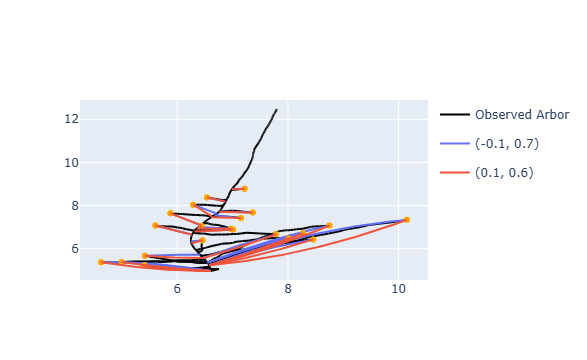

In [238]:
combos = ["opt", (0.1, 0.6)]
arbor_comparison('001_1_C_day5.csv', combos)

In [231]:
import csv
with open("data/results/best_of_best.csv", 'r') as f:
    reader = csv.reader(f)
    for num, row in enumerate(reader):
        if num == 1:
            test = row
            break
test

['043_5_S_day5', '  -0.20', '  0.73', '  0.000022']